# Lab 3: Clustering

## Group 1: Kebur Fantahun, Eli Kravez, Halle Purdom, Anthony Egbuniwe

#### Reference: 

To run this notebook, place bank-additional-full.csv dataset in the same folder as this notebook. 

This notebook takes about 51 minutes to run.

In [1]:
# Starting timer for notebook
import time
global_t_start = time.time()

In [2]:
#Import Libraries

import pandas as pd
import numpy as np

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Train/test split
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import train_test_split 

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from ipywidgets import widgets as wd

from sklearn.preprocessing import StandardScaler # Normalize

# SVM
from sklearn.svm import SVC
from pandas.plotting import boxplot

from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc

from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import seaborn as sns

from sklearn import linear_model
from sklearn.feature_selection import  RFECV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import ShuffleSplit 
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

## Business Understanding

In order to evaluate the success of their bank telemarketing campaigns, a Portuguese banking institution collected data on their customers including whether or not a customer subscribed to a term deposit. These variables included factors dependent on the individual customer’s telemarketing experience and unrelated factors such as marital status, education, and job.

In part one of our analysis, we creat a random forest classifier to predict whether or not a customer will subscribe to a term deposit. To determine a good algorithm, we looked at accuracy, precision and recall to see if clustering improves the models. We will focus primarily on recall because in the random forest classification recall is a priority for the bank data as asking for a high recall minimizes false negatives. This will yield more profit because correctly classifying a person as a ‘yes’ to subscribing to a term deposit in general should increase the number of subscriptions.

In our part two analysis of clustering on components from PCA, we used different methods such as the elbow method, silhouette score, BIC, and visualizations to find the best clustering for the data. Then based on domain knowledge and all the results determined what the best clustering for a specific method would be. 

## Data Understanding and Preparation

| Number      | Attribute | Meaning | Type/Scale |
| ----------- | ----------- | ----------- | ----------- |
|**Bank customer data:** |
| 1      | age       | Age of customer | numeric: 17-98 |
| 2   | job        | Customer's job | categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown' |
| 3   | marital        | Customer's marital status | categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed |
| 4   | education        | Level of customer's education | categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown' |
| 5   | default        | Whether or not the customer has credit in default | categorical: 'no','yes','unknown' |
| 6   | housing        | Whether or not customer has a housing loan | categorical: 'no','yes','unknown'|
| 7   | loan        | Whether or not a customer has a personal loan  | categorical: 'no','yes','unknown'  |
|**Related with the last contact of the current campaign:** |
| 8   | contact        | Communication type | categorical: 'cellular','telephone' |
| 9   | month        | Last contact with customer month of year | categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec' |
| 10   | day_of_week        | Last contact with customer day of week | categorical: 'mon','tue','wed','thu','fri' |
| 11   | duration        | Last contact with customer duration in seconds | numeric: 0-4918;  "Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model." (Reference below) |
| **Other attributes :**|
| 12   | campaign | Number of contacts performed during this campaign and for this customer | numeric, includes last contact: 1-56|
| 13 | pdays | Number of days that passed by after the customer was last contacted from a previous campaign | numeric,  999 means client was not previously contacted: 0-999 |
| 14 | previous | Number of contacts performed before this campaign and for this customer | numeric: 0-7 |
| 15 |  poutcome | Outcome of the previous marketing campaign | categorical: 'failure','nonexistent','success' |
| **Social and economic context attributes:** |
|16 | emp.var.rate | Employment variation rate - quarterly indicator.  | numeric: -3.4-1.4 |
|17 | cons.price.idx | Consumer price index - monthly indicator | numeric: 92.201-94.767 |
|18 | cons.conf.idx | Consumer confidence index - monthly indicator | numeric: -50.8--26.9 |
|19 | euribor3m | Euribor 3 month rate - daily indicator. This is a daily reference rate produced by the  by the European Money Markets Institute, based on the averaged interest rates at which Eurozone banks offer to lend unsecured funds to other banks in the euro wholesale money market. | numeric: 0.634-5.045 |
|20 | nr.employed | Number of employees - quarterly indicator | numeric: 4963.6-5228.1 | 
| **Target Variable:** |
| 21 | y | Whether or not a customer subscribed to a term deposit | binary: 'yes','no' |

Reference: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [3]:
# Read in the data
bank_df = pd.read_csv("bank-additional-full.csv", sep=';')
# Drop duplicate rows from the data
bank_df.drop_duplicates(keep='first', inplace=True)

bank_df.info()

categ_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'education','poutcome']
continuous_features = ['age','duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 
                       'cons.conf.idx', 'euribor3m', 'nr.employed']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [4]:
# Normalization of the continuous variables
scl_obj = StandardScaler()
scl_obj.fit(bank_df[continuous_features]) 

bank_df[continuous_features] = scl_obj.transform(bank_df[continuous_features]) 

# Changing class 'y' variable into integer values; 'No'=0, 'Yes'=1
bank_df.y = (bank_df[['y']].y == 'yes').astype('int')

# One hot encoding for categorical variables
bank_df_processed = pd.get_dummies(bank_df)

# Checking dataset after above transformations
bank_df_processed.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.533143,0.010352,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,...,0,0,0,1,0,0,0,0,1,0
1,1.629107,-0.421577,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,...,0,0,0,1,0,0,0,0,1,0
2,-0.290177,-0.124626,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,...,0,0,0,1,0,0,0,0,1,0
3,-0.002284,-0.413864,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,...,0,0,0,1,0,0,0,0,1,0
4,1.533143,0.187751,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695,...,0,0,0,1,0,0,0,0,1,0


In [5]:
bank_df_processed[continuous_features].head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533143,0.010352,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
1,1.629107,-0.421577,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
2,-0.290177,-0.124626,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
3,-0.002284,-0.413864,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
4,1.533143,0.187751,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695


In [6]:
bank_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  float64
 1   duration                       41176 non-null  float64
 2   campaign                       41176 non-null  float64
 3   pdays                          41176 non-null  float64
 4   previous                       41176 non-null  float64
 5   emp.var.rate                   41176 non-null  float64
 6   cons.price.idx                 41176 non-null  float64
 7   cons.conf.idx                  41176 non-null  float64
 8   euribor3m                      41176 non-null  float64
 9   nr.employed                    41176 non-null  float64
 10  y                              41176 non-null  int64  
 11  job_admin.                     41176 non-null  uint8  
 12  job_blue-collar                41176 non-null 

In [7]:
# Look at dataset before downsample
X_train,X_test = train_test_split(bank_df_processed  ,  test_size=0.2,random_state=444)

y_count_yes = X_train['y'].value_counts()[1]

train_no = X_train[X_train['y']==0]
train_yes = X_train[X_train['y']==1]

train_downsample_no = resample(train_no, replace=False, n_samples=y_count_yes, random_state=444) 

bank_df_sample = pd.concat([train_yes, train_downsample_no])

# Show distribution after downsampling
bank_df_sample['y'].value_counts()

# Selected most important features from random forest in lab 2
random_forest_columns = ['duration', 'euribor3m', 'nr.employed', 'emp.var.rate', 'cons.conf.idx', 'campaign', 'cons.price.idx', 'pdays', 'poutcome_success',
	  'previous', 'month_may', 'y']

bank_df_sample = bank_df_sample[random_forest_columns]


In order to prepare our dataset for the clustering, first we dropped all duplicate rows. The continuous variables where then normalized and the categorical variables one hot encoded into dummy variables. Our binary class variable 'y' was converted to integer values 0 and 1, where 0 represents 'no' and 1 represents 'yes'. 

## Part One: Clustering as Feature Engineering
#### Reference: 09. Clustering and Discretization

First we used clustering to get a more accurate random forest classification model. Below we create a base random forest model, using the features that were found as most important from a previous random forest classifier in Lab 2. Then we perform clustering as an additional variable in the model to improve the statistics- accuracy, precision, and recall. The types of clustering explored include kmeans++, agglomerative, and dbscan, and each has their parameters optimized.

#### Base Random Forest Model

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = bank_df_sample['y']
X = bank_df_sample.drop('y', 1)

cv = StratifiedKFold(n_splits=10) # 10-fold cross validation

clf = RandomForestClassifier(n_estimators=150,random_state=1) # Creating base random forest model

# Statistics for random forest model (we will use these to compare to models with additional clustering )
acc = cross_val_score(clf,X,y=y,cv=cv)
precision = cross_val_score(clf,X,y=y,cv=cv, scoring = "precision")
recall = cross_val_score(clf,X,y=y,cv=cv, scoring = "recall")


In [9]:
print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
print ("Average precision = ", precision.mean()*100, "+-", precision.std()*100)
print ("Average recall = ", recall.mean()*100, "+-", recall.std()*100)

Average accuracy =  86.92404771552094 +- 1.0758160973901152
Average precision =  84.83511818910392 +- 1.507280885459058
Average recall =  89.96553059067018 +- 1.338380686598532


#### Kmeans Clustering for Random Forest Model

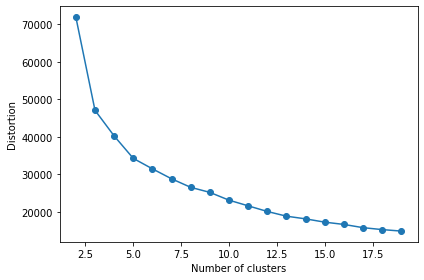

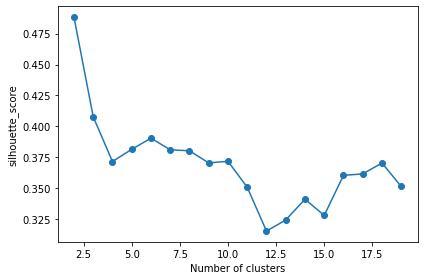

Wall time: 22.7 s


In [10]:
%%time 

from sklearn.cluster import KMeans

distortions = [] # For elbow method of parameter optimization
silhouette_score = [] # For silhouette score method of parameter optimization
X_km = bank_df_sample # Sample with chosen features for random forest

# Kmeans ++ model with varying cluster amount
for i in range(2, 20):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    km.fit(X_km)
    distortions.append(km.inertia_)
    
    labels_km = km.fit_predict(X_km)    
    silhouette_score_km = round(mt.silhouette_score(X_km, labels_km),4)
    silhouette_score.append(silhouette_score_km)


# Plotting distortion by number of clusters (within cluster SSE)
plt.plot(range(2, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

# Plotting silhouette score by number of clusters
plt.plot(range(2, 20), silhouette_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.tight_layout()
plt.show()

In [11]:
%%time 

# Running kmeans++ clustering with 3 clusters (as determined by above graphs)

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = X

cls = KMeans(n_clusters=3, init='k-means++',random_state=1) # Kmeans with 3 clusters
cls.fit(X1)
newfeature = cls.labels_ # The labels from kmeans clustering



Xnew = np.column_stack((X1,pd.get_dummies(newfeature)))

# Scaling the new clustering feature to add into random forest
scl_obj = StandardScaler()
scl_obj.fit(Xnew) 

newfeature = scl_obj.transform(Xnew)

# Getting statistics for new random forest classfiication model
acc = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "accuracy")
precision = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "precision")
recall = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "recall")

print ("Average accuracy (with kmeans)= ", acc.mean()*100, "+-", acc.std()*100)
print ("Average precision (with kmeans)= ", precision.mean()*100, "+-", precision.std()*100)
print ("Average recall (with kmeans)= ", recall.mean()*100, "+-", recall.std()*100)


Average accuracy (with kmeans)=  86.80130180550239 +- 0.952226369278464
Average precision (with kmeans)=  84.7897833947824 +- 1.5346986674600887
Average recall (with kmeans)=  89.74702580366582 +- 1.3924463875246555
Wall time: 15.4 s


#### Agglomerative Clustering for Random Forest Model

In [12]:
%%time 

# Agglomerative clustering model 

from sklearn.cluster import AgglomerativeClustering

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(2,20):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X1)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
        
        Xnew = np.column_stack((X1,pd.get_dummies(newfeature_fam)))

        scl_obj = StandardScaler()
        scl_obj.fit(Xnew) 

        newfeature = scl_obj.transform(Xnew)

        acc = cross_val_score(clf,newfeature,y=y,cv=cv)
        precision = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "precision")
        recall = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "recall")

        print ("C=",n_fam,link,"Average precision = ", precision.mean()*100, "+-", precision.std()*100)
        print ("Average accuracy (with kmeans)= ", acc.mean()*100, "+-", acc.std()*100)
        print ("Average recall = ", recall.mean()*100, "+-", recall.std()*100)
        print ("------------------------------------------------------------------------------------------------")

C= 2 ward Average precision =  84.90423026944762 +- 1.4727542929199717
Average accuracy (with kmeans)=  86.9922047797302 +- 1.042187927578492
Average recall =  90.0195053676985 +- 0.9093573553584422
------------------------------------------------------------------------------------------------
C= 3 ward Average precision =  84.7342674548176 +- 1.5067272274522503
Average accuracy (with kmeans)=  86.80137615190458 +- 0.9393399788330257
Average recall =  89.82899301678057 +- 1.3353164272749458
------------------------------------------------------------------------------------------------
C= 4 ward Average precision =  84.68442434913564 +- 1.6319863346609274
Average accuracy (with kmeans)=  86.76046704409858 +- 1.1776082621803587
Average recall =  89.80144726850403 +- 1.332571278513285
------------------------------------------------------------------------------------------------
C= 5 ward Average precision =  84.74323918664233 +- 1.5667830189140106
Average accuracy (with kmeans)=  86.8

#### DBSCAN Clustering for Random Forest Model

In [13]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15, 1]:
    for mpts in range(2,15):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering
        
        Xnew = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        scl_obj = StandardScaler()
        scl_obj.fit(Xnew) 

        newfeature = scl_obj.transform(Xnew)
      

        acc = cross_val_score(clf,newfeature,y=y,cv=cv)        
        precision = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "precision")
        recall = cross_val_score(clf,newfeature,y=y,cv=cv, scoring = "recall")
        

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)
        print (eps,mpts,"Average precision = ", precision.mean()*100, "+-", precision.std()*100)
        print (eps,mpts,"Average recall = ", recall.mean()*100, "+-", recall.std()*100)
        


0.1 2 Average accuracy =  85.83331164896603 +- 1.2954061478772743
0.1 2 Average precision =  84.23924983527759 +- 1.5761566571199785
0.1 2 Average recall =  88.19277556915472 +- 1.2890915003450583
0.1 3 Average accuracy =  85.98337986179004 +- 1.3374001778816889
0.1 3 Average precision =  84.30336792828987 +- 1.5519297106625607
0.1 3 Average recall =  88.46577626896564 +- 1.7644530988839806
0.1 4 Average accuracy =  86.16069603101731 +- 1.3138184400399857
0.1 4 Average precision =  84.48210798713302 +- 1.6044316016639013
0.1 4 Average recall =  88.62948735129021 +- 1.4646877639107607
0.1 5 Average accuracy =  86.40605774485059 +- 1.1911344133792907
0.1 5 Average precision =  84.6804816032147 +- 1.551115841168254
0.1 5 Average recall =  88.92906597578951 +- 1.2132190419226838
0.1 6 Average accuracy =  86.48783878726147 +- 1.195253896644326
0.1 6 Average precision =  84.66243045893144 +- 1.452208967688732
0.1 6 Average recall =  89.14727297092062 +- 1.2409358521060687
0.1 7 Average accur

### Part One Evaluation: Random Forest Classification Model Comparison


#### Validation Measures
For kmeans++ clustering the optimal number of clusters was chosen through the elbow method and the silhouette score method. The elbow method uses the distortion metric (within cluster SSE) to find the optimal value in the "elbow" of the graph. The silhouette score metric takes into account the similarity of objects within the same cluster as well as distance to objects in other clusters. From both of these graphs, we decided on 3 clusters. 

For agglomerative clustering, we optimized the number of clusters by varying cluster number and finding the highest precision associated with that classifier. 

For DBSCAN clustering, we optimized the parameters eps and min_points. Eps refers to the max distance between two objects to be considered as part of the same cluster. Min_points refers to the number of objects in a cluster for a specific point to considered a core point (a point in a high density area). By optimizing these variables, we can find the optimal number of clusters. 

#### Model Comparison

| Model      | Accuracy | Precision | **Recall** |
| ----------- | ----------- | ----------- | ----------- |
| Base | 86.92  | 84.84 | **89.97** |
| Kmeans++ | 86.80 | 84.79  | **89.75** |
| Agglomerative | 86.88 | 84.71 | **90.04** |
| DBSCAN | 86.38 | 84.60 | **88.98** |

Best Parameters:
- Kmeans ++: clusters=3
- Agglomerative: C=2, 'average'
- DBSCAN: eps=0.15 min_points=8 

Based on recall, the best performing model was the random forest classifier that used agglomerative clustering. As seen above, all the differences in performance by the models are very small, and the standard deviations in most cases are larger than these differences. While the agglomerative metrics are the best, there was such a small difference between each model that they mostly all performed very similarly to each other. 

The evaluation metrics included are accuracy, precision, and recall. As mentioned in business understanding, in the random forest classification recall is a priority for the bank data as asking for a high recall minimizes false negatives. This will yield more profit because correctly classifying a person as a ‘yes’ to subscribing to a term deposit in general should increase the number of subscriptions.

## Part Two: Clustering using PCA

In the next section we will use PCA for data reduction in clustering. This also helps to increase the computation time of the clustering. 

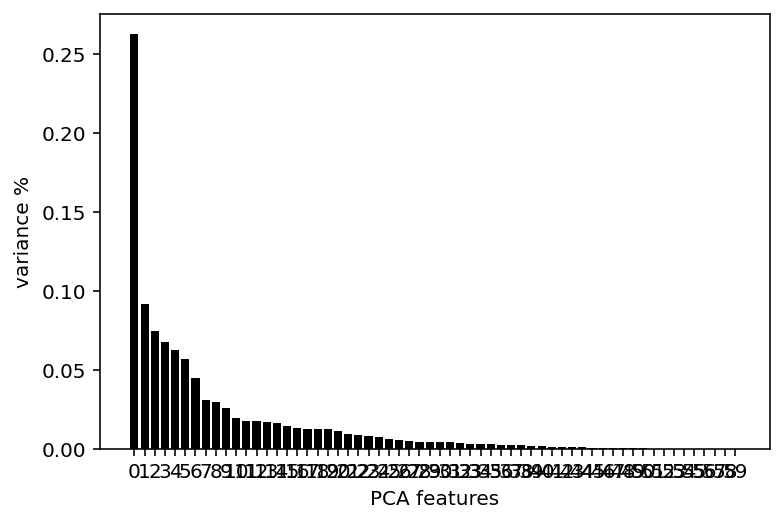

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Load in the data
X_std = bank_df_processed

# Create a PCA instance: pca
pca = PCA(n_components=60)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

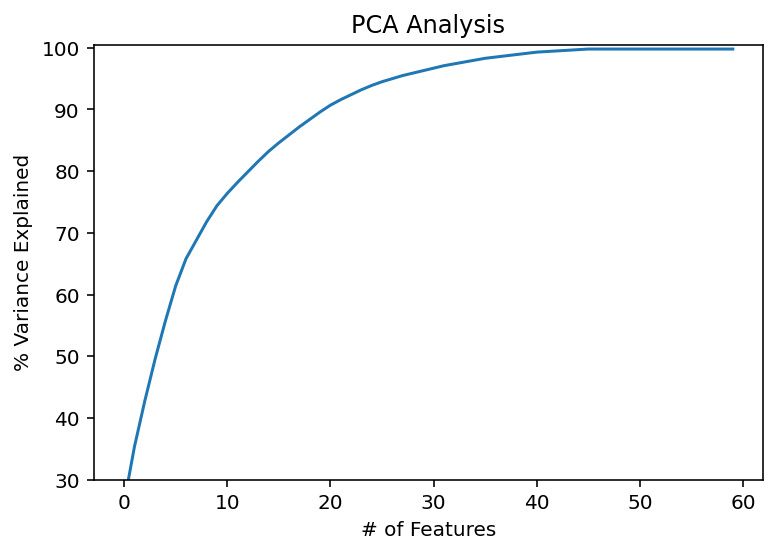

In [10]:
# Visualizing PCA features
covar_matrix = PCA(n_components = 60) # We have 20 features
covar_matrix.fit(X_std)
variance = covar_matrix.explained_variance_ratio_ # Calculate variance ratios

# Creating plot
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var # Cumulative sum of variance explained with [n] features

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

The plot above shows as number of features in PCA increases, variance explained increases in the above fashion. 

Text(0, 0.5, 'PCA 2')

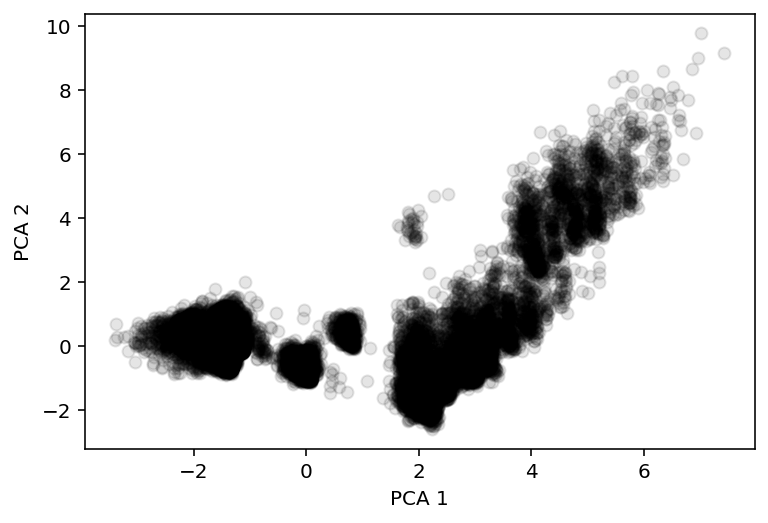

In [11]:
# Plotting PCA 1 and PCA 2
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In the visualization of PCA 1 and 2, we can see clearer clusters in the reduced data. 

#### Kmeans++ Clustering

 k= 2 silhouette: 0.2711
 k= 3 silhouette: 0.2696
 k= 4 silhouette: 0.1378
 k= 5 silhouette: 0.1442
 k= 6 silhouette: 0.1478
 k= 7 silhouette: 0.1297
 k= 8 silhouette: 0.1373
 k= 9 silhouette: 0.1383
Wall time: 2min 1s


[Text(0, 0.5, 'inertia'), Text(0.5, 0, 'k'), Text(0.5, 1.0, 'Inertia K-Means')]

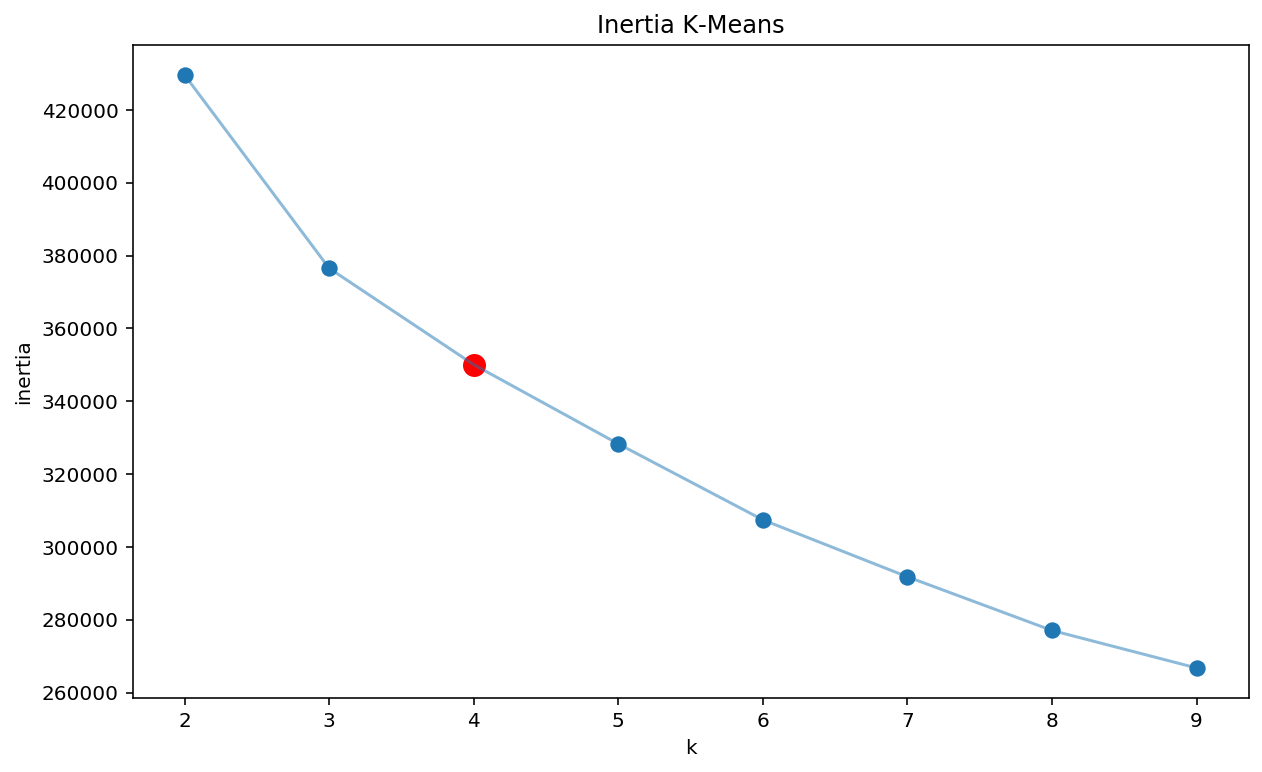

In [17]:
%%time 

# Kmeans++ clustering on PCA
ks = range(2, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:20])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
    labels_km = model.fit_predict(X_std)    
    silhouette_score_km = round(mt.silhouette_score(X_std, labels_km),4) # Calculating silhouette score for evaluation
    print(" k= " + str(k) +  " silhouette: " + str(silhouette_score_km)) # Print scores to evaluate clustering
    #silhouette_score.append(silhouette_score_km)
    
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=ks, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[ks[2]], y = [inertias[2]], color='red', s=150, ax=ax)
sns.lineplot(x=ks, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');




Kmeans clustering on PCA data. The above visualization is used to perform the elbow method to determine the best amount of clusters. 

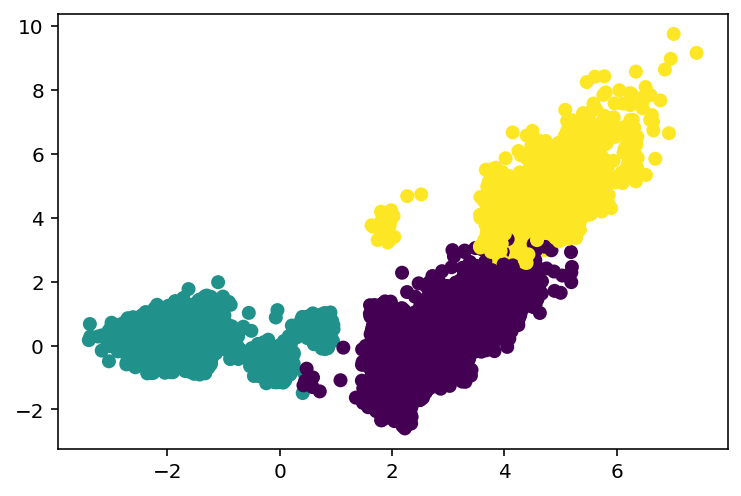

Wall time: 1.93 s


In [18]:
%%time 

# Clustering PCA 1 and 2
model = KMeans(n_clusters=3, init='k-means++')
model.fit(PCA_components.iloc[:,:20])

labels = model.predict(PCA_components.iloc[:,:20])

plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

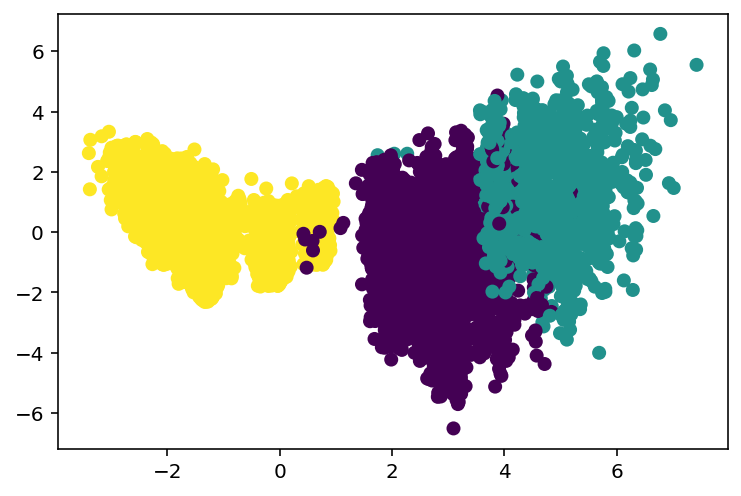

Wall time: 1.93 s


In [19]:
%%time 

# Clustering PCA 1 and 3
model = KMeans(n_clusters=3, init='k-means++')
model.fit(PCA_components.iloc[:,:20])

labels = model.predict(PCA_components.iloc[:,:20])

plt.scatter(PCA_components[0], PCA_components[2], c=labels)
plt.show()

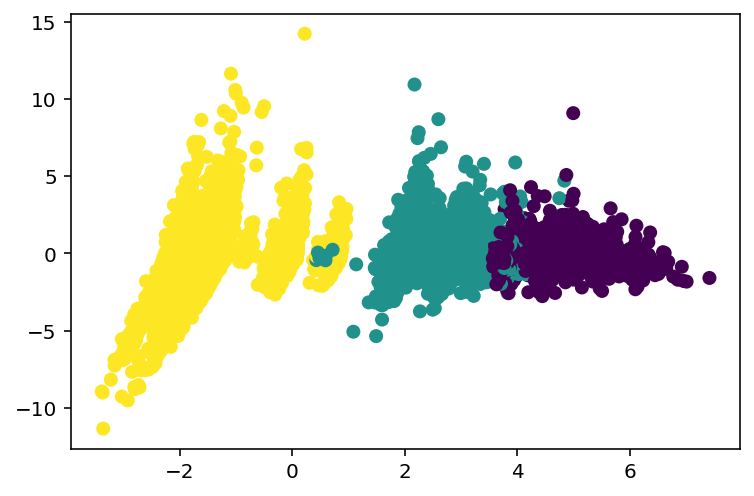

In [20]:
# Clustering PCA 1 and 4
model = KMeans(n_clusters=3, init='k-means++')
model.fit(PCA_components.iloc[:,:20])

labels = model.predict(PCA_components.iloc[:,:20])

plt.scatter(PCA_components[0], PCA_components[3], c=labels)
plt.show()

#### Gaussian Mixture Model Clustering

In [21]:
%%time 

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Loop through varying number of PCA components in clustering model
X = PCA_components.iloc[:,:30] 

lowest_bic = np.infty
bic = [] # Using BIC metric to find best clustering model 
n_components_range = range(1, 30)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM (expectation maximization algorithm)
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm # Find best clustering model

Wall time: 5min 57s


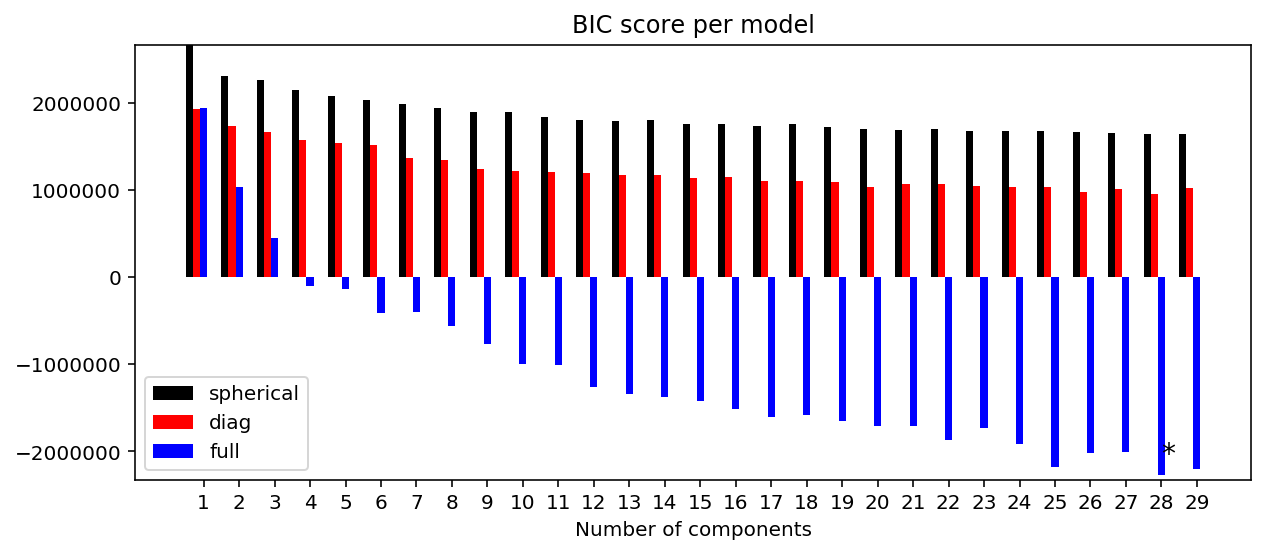

Wall time: 353 ms


In [22]:
%%time 

# Reference: Sklearn website documentation: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
# Calculating BIC for different gmm models to find best parameters (type and # components)

# Plot the BIC for each model
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)

# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

Calculating BIC scores for different clustering models varying type (spherical, diag, full) and number of components. As identified above, full at 28 components minimizes BIC. For each run of the code, this value varies slightly (25, 28, 29, etc.) We will be using the past value of 25 below, but no matter the variance the clustering is generally the same, not so great performance. 

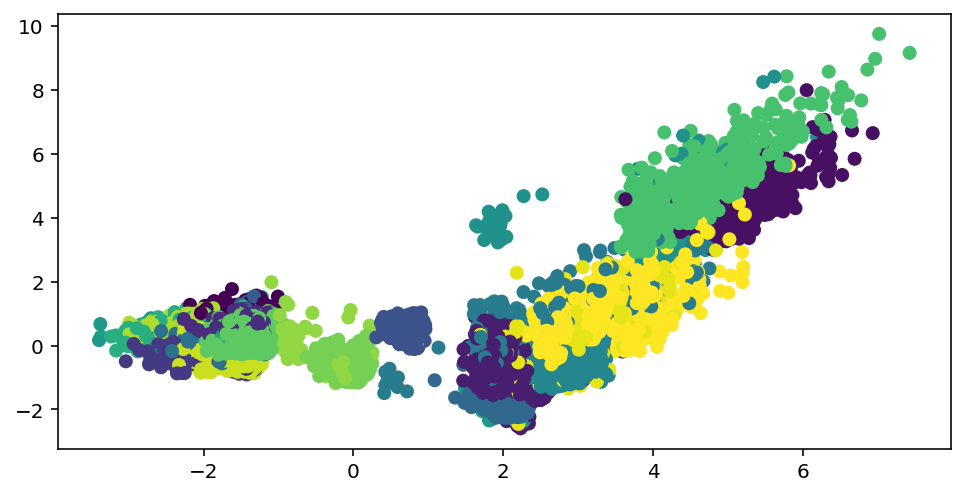

In [23]:
# Plotting gmm clustering with 25 clusters
# (This was based on previous lowest BIC value, above is slightly different but essentailly same results)
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)

X = PCA_components.iloc[:,:30]
gmmN = mixture.GaussianMixture(n_components=25, covariance_type='full')
gmmN.fit(X)
    
labels = gmmN.predict(X)

plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

Visualization of recommended gmm clustering based on BIC. Based on domain knowledge, we will try clustering with less clusters below. 

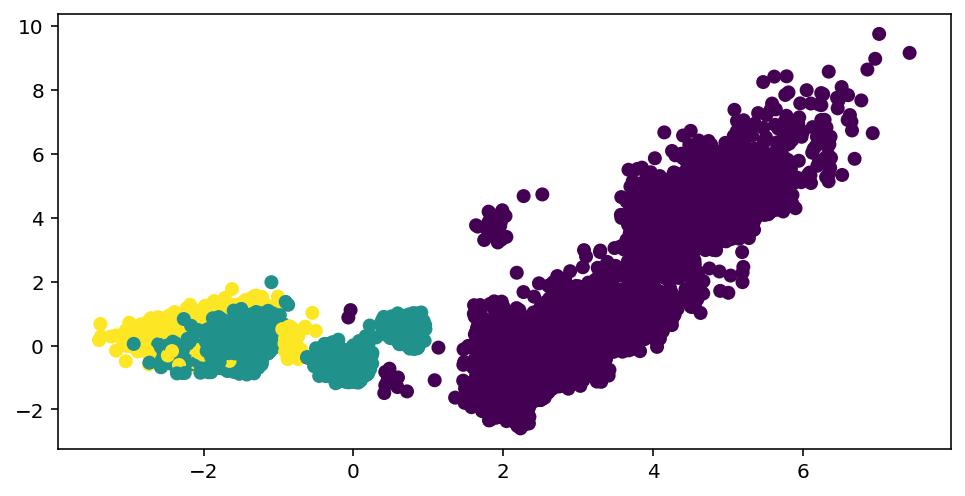

In [24]:
# Gmm clustering with 3 clusters on PCA data
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)

X = PCA_components.iloc[:,:30]
gmmN = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmmN.fit(X)
    
labels = gmmN.predict(X)

plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

Testing out gmm clustering with 3 clusters instead of the 25 as chosen above. Clustering looks a little better but still not performing as well as kmeans.  

#### Spectral Clustering

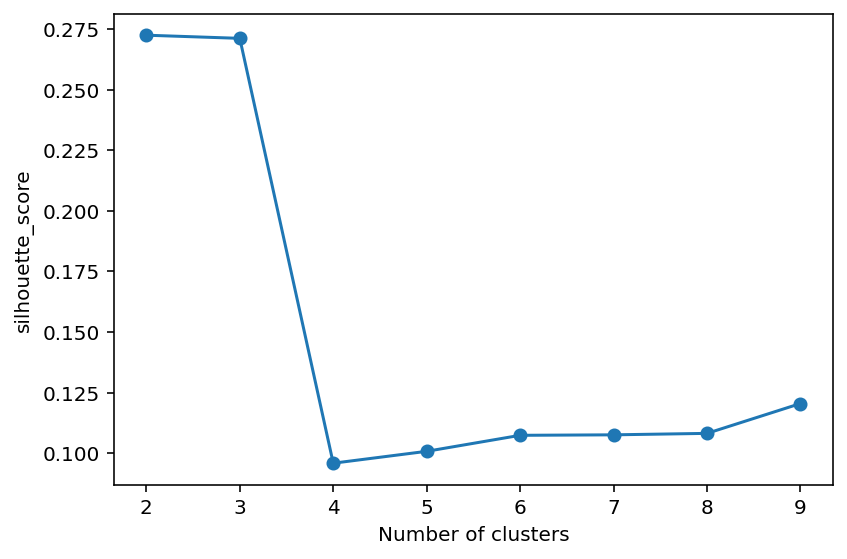

CPU times: user 15min 54s, sys: 23.6 s, total: 16min 17s
Wall time: 4min 35s


In [13]:
%%time 

from sklearn.cluster import SpectralClustering

pca_sample = PCA_components.sample(frac=0.3, replace=False, random_state=1) # Sampling to speed up clustering

distortions = [] # For elbow method of parameter optimization
silhouette_score = [] # For silhouette score method of parameter optimization


# Spectral Clustering model with varying cluster amount
for i in range(2, 10):
    sc = SpectralClustering(n_clusters=i, affinity = 'nearest_neighbors')
    sc.fit_predict(pca_sample)    
    
    labels_sc = sc.fit_predict(pca_sample)    
    silhouette_score_sc = round(mt.silhouette_score(pca_sample, labels_sc),4)
    silhouette_score.append(silhouette_score_sc)


# Plotting silhouette score by number of clusters
plt.plot(range(2, 10), silhouette_score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.tight_layout()
plt.show()

In [14]:
%%time 

# Spectral clustering on PCA
X = pca_sample.iloc[:,:30] 
nclust = 3 # Setting 3 clusters

spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X) # Fitting clustering model to data

CPU times: user 45.3 s, sys: 1.19 s, total: 46.5 s
Wall time: 13.6 s


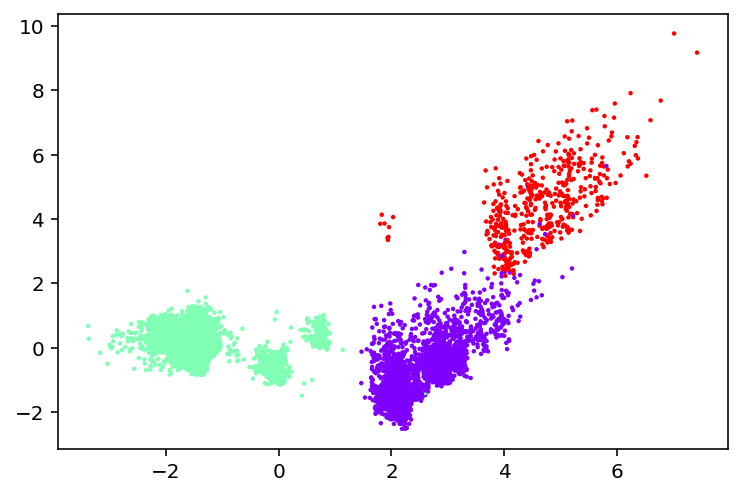

In [15]:
# Plotting spectral clustering results
plt.scatter(pca_sample[0], pca_sample[1], c=labels,
                     cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

Spectral clustering grouping the data into 5 clusters. This is based off a sample of the data to minimize computation time. The model clusters the data well as seen above. 

#### Knn Analysis of PCA components (For Determining DBSCAN Parameter)

For the DBSCAN clustering, we are switching to use the first 4 PCA values because of performance issues. These first four values capture the majority of the variance. 

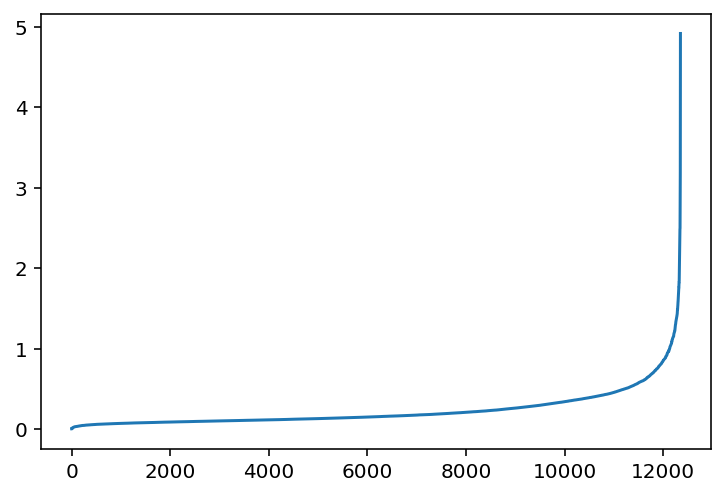

In [28]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 100) # Vary this parameter to get best visualization below
nbrs = neigh.fit(X.iloc[:,:6]) # Using first 6 PCA because of large dataset

distances, indices = nbrs.kneighbors(X.iloc[:,:6]) # Calculating  nearest neighbors distance

# Plotting Knn graph to determine best DBSCAN parameters
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

The above nearest neighbors graph is used to tune the below parameters for the DBSCAN clustering. 

#### DBSCAN Clustering

In [29]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps= 1.3, min_samples=100) # Base

# Then fit the model to your data using the fit method
model = dbscan.fit_predict(X.iloc[:,:6])

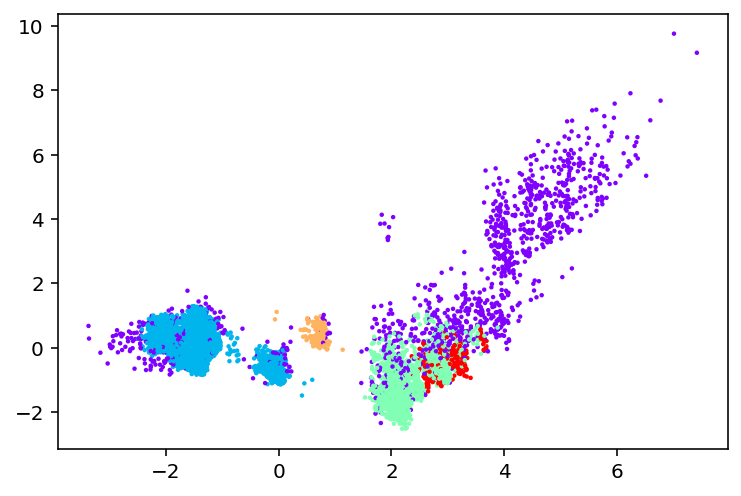

In [30]:
# Plot DBSCAN clustering of PCA
plt.scatter(pca_sample[0], pca_sample[1], c=model,
                     cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

After varying the parameters eps and min_samples, the best clustering results are shown above. DBSCAN clustering is not performing the best when compared to our other clustering methods.  

### Part Two Evaluation: Clustering on PCA data

Because our dataset was so large, performing PCA on the dataset reduced computation time and made it possible to cluster the data and visually evaluate that clustering. In the above models, we explored kmeans, gmm, spectral, and DBSCAN clustering on the PCA data. 

#### Clustering Optimization
In order to choose the best parameters for each model, we were able to visually evaluate the clusters now that the dataset was reduced through PCA. For both kmeans and spectral clustering, we used the visualizations to find the best clusterings. With gmm clustering, we also optimized the model using the BIC score to find the best parameters and clustering type. The BIC metric however did not give us the most optimal clustering result, and we used domain knowledge and visualizations to find better clustering for the data. Lastly, in the DBSCAN clustering we used a k nearest neighbors graph to find the best eps and min_sample variables for the clustering.

#### Model Comparison
In the end, the kmeans model performed very well with 3 clusters the PCA components based on the visualizations of PCA 1&2, 1&3, and 1&4. The spectral clustering also visually performed very well with 3 clusters, with clear logical clusters seen in the visualization. The gmm model, while performing better with the 3 clusters than the recommended 25, did not perform as well because the two left clusters were mixed amongst themselves. Lastly, DBSCAN clustering did not perform very well with the data, even as parameters were varied. 

### Deployment

This specific dataset is from the Portuguese banking institution and related to their direct marketing campaigns. 

The random forest classification models explored above would interest the bank to be used as tools to predict whether or not a specific customer will subscribe to a term deposit in future campaigns. The attributes that built the prediction model can be classified into attributes about the specific customer, attributes about the marketing campaign, and attributes based around the social and economic status of the time. The bank can predict whether or not a new customer will subscribe to a term deposit based on customer attributes, which will tell them where to devote their resources towards likely ‘successes’ in order to maximize profit. This data will also show them what a successful marketing campaign looks like (e.g.  when a customer was contacted, for how long, what frequency of calls the customer received, etc.). Lastly, it will give them social and economic indicators on when the best time to run a successful campaign would be. 

The classification model's value would be determined by comparing the ratio of successes to failures before the model was implemented and after the model was implemented. Ideally we would want to see the successes rising when all of the above recommendations are taken into consideration. As time goes on and more telemarketing campaigns occur, these new datapoints should be added to the dataset to further refine the model and dynamically improve the model over time. 

While the classification in part one would be very useful to the bank, the clustering in part two is more oriented towards exploratory data analysis. This analysis could then be useful to data scientists working with the bank data, but would not be so useful for the bank leadership themselves. 

In [31]:
# End timer for notebook
global_t_end = time.time() - global_t_start
print(global_t_end)

3043.3571486473083
